In [ ]:
!pip install lime -q

In [ ]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import warnings
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer
from sklearn.feature_selection import RFE

In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
file_path = "/content/Lung Cancer Dataset.csv"
df = pd.read_csv(file_path)
df

,AGE,GENDER,SMOKING,FINGER_DISCOLORATION,MENTAL_STRESS,EXPOSURE_TO_POLLUTION,LONG_TERM_ILLNESS,ENERGY_LEVEL,IMMUNE_WEAKNESS,BREATHING_ISSUE,ALCOHOL_CONSUMPTION,THROAT_DISCOMFORT,OXYGEN_SATURATION,CHEST_TIGHTNESS,FAMILY_HISTORY,SMOKING_FAMILY_HISTORY,STRESS_IMMUNE,PULMONARY_DISEASE
0,68,1,1,1,1,1,0,57.831178,0,0,1,1,95.977287,1,0,0,0,NO
1,81,1,1,0,0,1,1,47.694835,1,1,0,1,97.184483,0,0,0,0,YES
2,58,1,1,0,0,0,0,59.577435,0,1,1,0,94.974939,0,0,0,0,NO
3,44,0,1,0,1,1,0,59.785767,0,1,0,1,95.187900,0,0,0,0,YES
4,72,0,1,1,1,1,1,59.733941,0,1,0,1,93.503008,0,0,0,0,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,32,0,1,1,0,0,1,60.700696,1,1,1,1,94.012495,0,1,1,0,YES
4996,80,0,1,1,1,1,1,50.751741,0,1,1,1,94.394968,0,0,0,0,YES
4997,51,1,0,0,1,0,0,61.063496,1,0,0,0,98.108901,0,0,0,1,NO
4998,76,1,0,1,0,0,0,48.662872,0,1,0,1,95.577773,1,0,0,0,NO


In [ ]:
df = pd.read_csv(file_path)
print("Dataset shape:", df.shape)
print(df.head())

Dataset shape: (5000, 18)
   AGE  GENDER  SMOKING  FINGER_DISCOLORATION  MENTAL_STRESS  \
0   68       1        1                     1              1   
1   81       1        1                     0              0   
2   58       1        1                     0              0   
3   44       0        1                     0              1   
4   72       0        1                     1              1   

   EXPOSURE_TO_POLLUTION  LONG_TERM_ILLNESS  ENERGY_LEVEL  IMMUNE_WEAKNESS  \
0                      1                  0     57.831178                0   
1                      1                  1     47.694835                1   
2                      0                  0     59.577435                0   
3                      1                  0     59.785767                0   
4                      1                  1     59.733941                0   

   BREATHING_ISSUE  ALCOHOL_CONSUMPTION  THROAT_DISCOMFORT  OXYGEN_SATURATION  \
0                0                    1

In [ ]:
# Missing Value
missing_values = df.isnull().sum()
print("Missing Values:")
print(missing_values)

Missing Values:
AGE                       0
GENDER                    0
SMOKING                   0
FINGER_DISCOLORATION      0
MENTAL_STRESS             0
EXPOSURE_TO_POLLUTION     0
LONG_TERM_ILLNESS         0
ENERGY_LEVEL              0
IMMUNE_WEAKNESS           0
BREATHING_ISSUE           0
ALCOHOL_CONSUMPTION       0
THROAT_DISCOMFORT         0
OXYGEN_SATURATION         0
CHEST_TIGHTNESS           0
FAMILY_HISTORY            0
SMOKING_FAMILY_HISTORY    0
STRESS_IMMUNE             0
PULMONARY_DISEASE         0
dtype: int64


In [ ]:
# Ensure target is 0/1
if df['PULMONARY_DISEASE'].dtype == 'object':
    df['PULMONARY_DISEASE'] = df['PULMONARY_DISEASE'].map({'YES': 1, 'NO': 0})
    df['PULMONARY_DISEASE'] = df['PULMONARY_DISEASE'].astype(int)

print("Class distribution before SMOTE:")
print(df['PULMONARY_DISEASE'].value_counts())

Class distribution before SMOTE:
PULMONARY_DISEASE
0    2963
1    2037
Name: count, dtype: int64


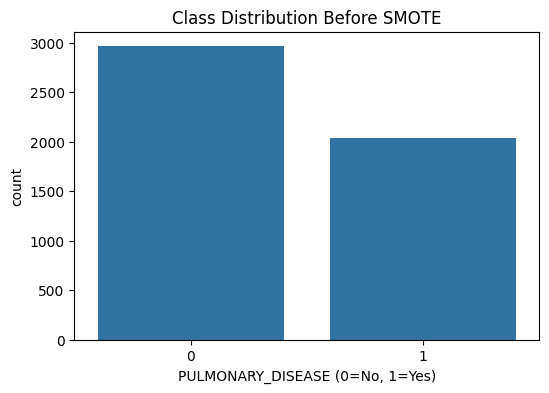

In [ ]:
# Plot class distribution
plt.figure(figsize=(6,4))
sns.countplot(x='PULMONARY_DISEASE', data=df)
plt.title('Class Distribution Before SMOTE')
plt.xlabel('PULMONARY_DISEASE (0=No, 1=Yes)')
plt.savefig('class_distribution_before.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# Features and target
X = df.drop(['PULMONARY_DISEASE'], axis=1)
y = df['PULMONARY_DISEASE']

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

df_scaled = pd.concat([X_scaled, y.reset_index(drop=True)], axis=1)
print(df_scaled.head())

        AGE    GENDER   SMOKING  FINGER_DISCOLORATION  MENTAL_STRESS  \
0  0.682203  0.997603  0.707531              0.814457       0.923330   
1  1.505110  0.997603  0.707531             -1.227812      -1.083037   
2  0.049197  0.997603  0.707531             -1.227812      -1.083037   
3 -0.837011 -1.002403  0.707531             -1.227812       0.923330   
4  0.935405 -1.002403  0.707531              0.814457       0.923330   

   EXPOSURE_TO_POLLUTION  LONG_TERM_ILLNESS  ENERGY_LEVEL  IMMUNE_WEAKNESS  \
0               0.968496          -0.884967      0.353770        -0.807680   
1               0.968496           1.129985     -0.927318         1.238115   
2              -1.032529          -0.884967      0.574472        -0.807680   
3               0.968496          -0.884967      0.600802        -0.807680   
4               0.968496           1.129985      0.594252        -0.807680   

   BREATHING_ISSUE  ALCOHOL_CONSUMPTION  THROAT_DISCOMFORT  OXYGEN_SATURATION  \
0        -2.00250

In [ ]:
x = df_scaled.drop(columns=['PULMONARY_DISEASE'])
y = df_scaled['PULMONARY_DISEASE']

smote = SMOTE(k_neighbors=5, random_state=42)
X_resampled, y_resampled = smote.fit_resample(x, y)

df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled['PULMONARY_DISEASE'] = y_resampled

print(df_resampled.shape)
df_resampled.describe()

(5926, 18)


,AGE,GENDER,SMOKING,FINGER_DISCOLORATION,MENTAL_STRESS,EXPOSURE_TO_POLLUTION,LONG_TERM_ILLNESS,ENERGY_LEVEL,IMMUNE_WEAKNESS,BREATHING_ISSUE,ALCOHOL_CONSUMPTION,THROAT_DISCOMFORT,OXYGEN_SATURATION,CHEST_TIGHTNESS,FAMILY_HISTORY,SMOKING_FAMILY_HISTORY,STRESS_IMMUNE,PULMONARY_DISEASE
count,5926.000000,5926.000000,5926.000000,5926.000000,5926.000000,5926.000000,5926.000000,5926.000000,5926.000000,5926.000000,5926.000000,5926.000000,5926.000000,5926.000000,5926.000000,5926.000000,5926.000000,5926.000000
mean,-0.003062,0.001008,0.093160,0.012716,0.007095,0.013791,-0.001186,0.035560,0.019779,0.056804,-0.007813,0.062123,-0.004176,0.012742,0.014680,0.053046,0.022351,0.500000
std,0.987249,0.995051,0.959716,0.993251,0.996909,0.994120,0.996510,0.976574,1.001618,0.951607,0.993633,0.967599,0.972895,0.993438,1.005984,1.036827,1.015661,0.500042
min,-1.723219,-1.002403,-1.413365,-1.227812,-1.083037,-1.032529,-0.884967,-4.015743,-0.807680,-2.002503,-0.740586,-1.521004,-3.422173,-1.226277,-0.657461,-0.506242,-0.514958,0.000000
25%,-0.837011,-1.002403,-1.413365,-1.227812,-1.083037,-1.032529,-0.884967,-0.645098,-0.807680,0.499375,-0.740586,-1.521004,-0.668972,-1.226277,-0.657461,-0.506242,-0.514958,0.000000
50%,-0.014103,0.171567,0.707531,0.814457,0.923330,0.968496,-0.884967,0.040379,-0.807680,0.499375,-0.740586,0.657461,-0.011450,0.815476,-0.657461,-0.506242,-0.514958,0.500000
75%,0.808804,0.997603,0.707531,0.814457,0.923330,0.968496,1.129985,0.682265,1.238115,0.499375,1.350283,0.657461,0.630503,0.815476,1.521004,-0.506242,-0.514958,1.000000
max,1.695012,0.997603,0.707531,0.814457,0.923330,0.968496,1.129985,3.540684,1.238115,0.499375,1.350283,0.657461,3.244485,0.815476,1.521004,1.975338,1.941904,1.000000


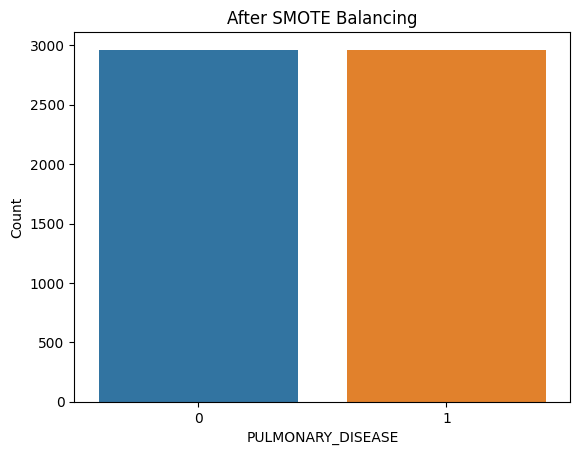

In [ ]:
sns.countplot(x='PULMONARY_DISEASE', data=df_resampled, hue='PULMONARY_DISEASE', legend=False)
plt.title('After SMOTE Balancing')
plt.xlabel('PULMONARY_DISEASE')
plt.ylabel('Count')
plt.savefig('After_SMOTE_Balancing.pdf', bbox_inches='tight')
plt.show()

In [ ]:
print(df_resampled['PULMONARY_DISEASE'].value_counts())

PULMONARY_DISEASE
0    2963
1    2963
Name: count, dtype: int64


In [ ]:
X_res = df_resampled.drop('PULMONARY_DISEASE', axis=1)
y_res = df_resampled['PULMONARY_DISEASE']

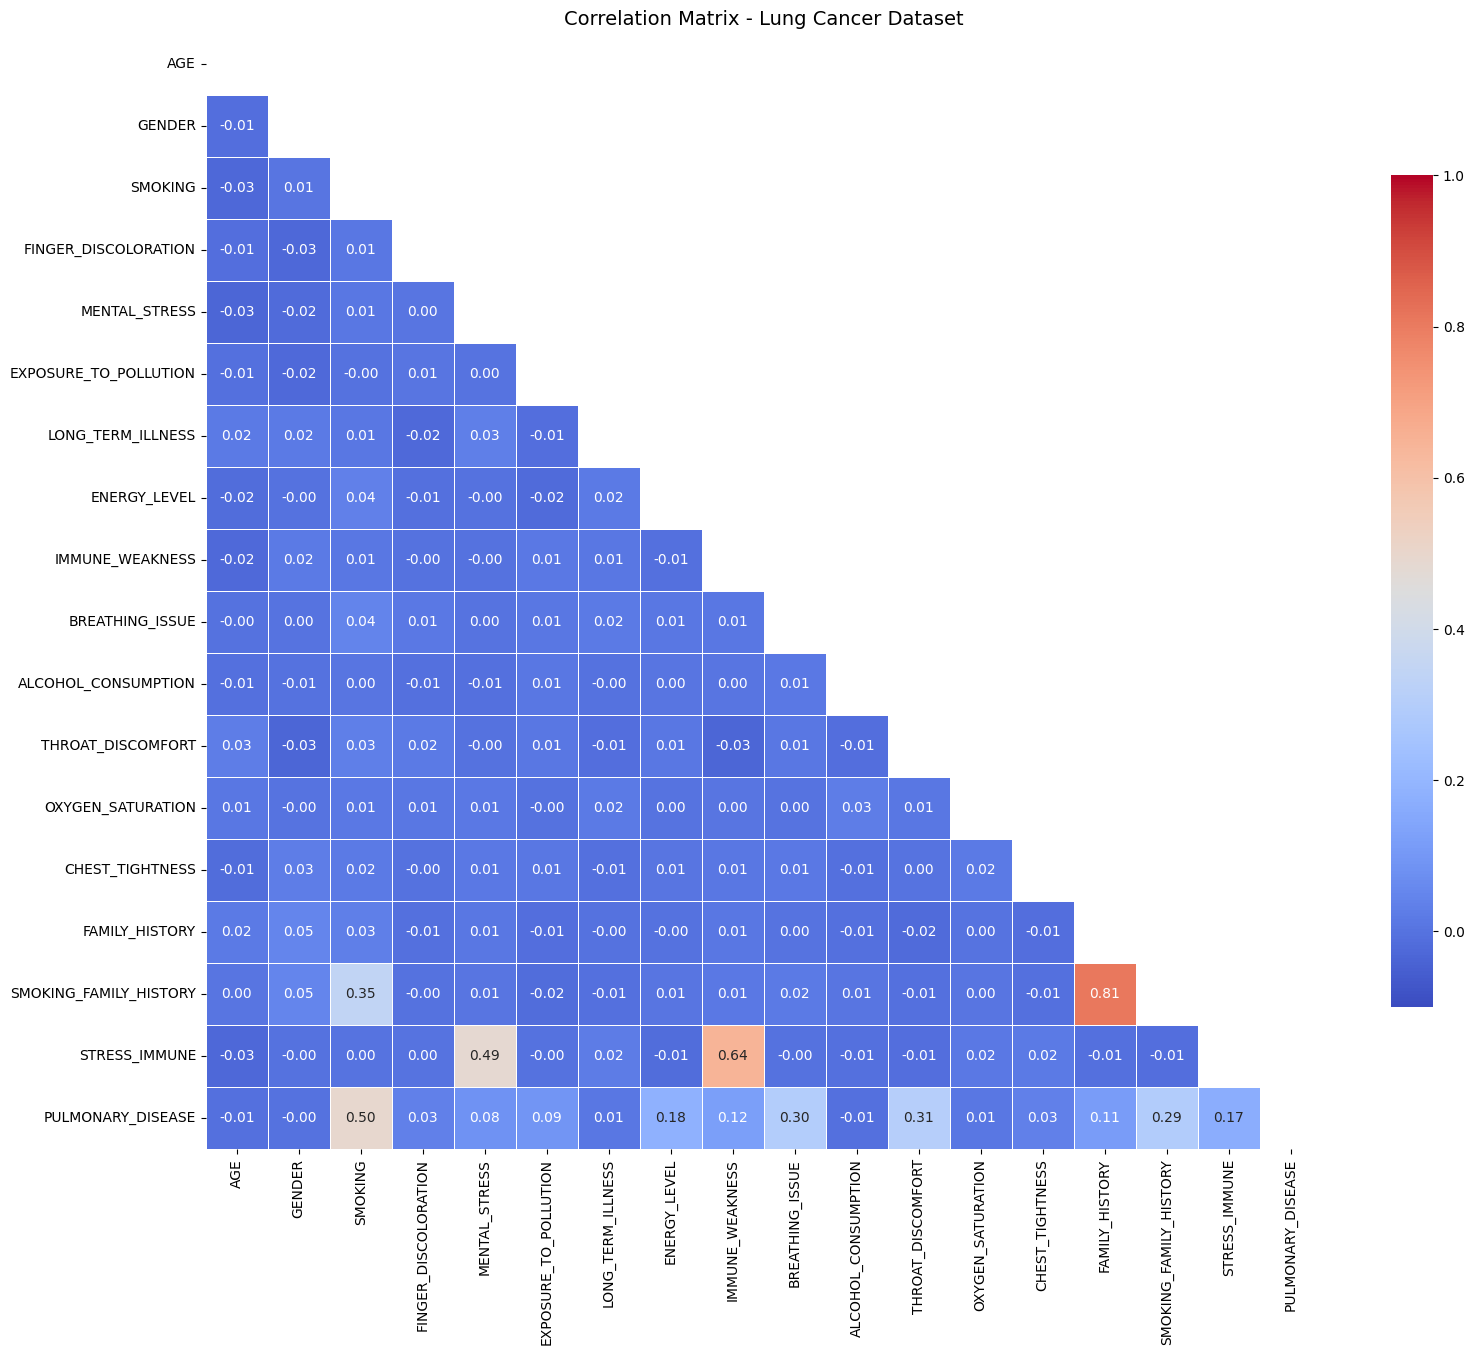

In [ ]:
corr = df_resampled.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(18, 18))
fig = sns.heatmap(corr, vmin=-0.1, vmax=1.0, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
                  square=True, linewidths=0.5, cbar_kws={"shrink":0.6})
plt.title("Correlation Matrix - Lung Cancer Dataset", fontsize=14)
plt.savefig("Correlation_LungCancer.pdf")
plt.show()

                   Feature  Gain Ratio
2                  SMOKING    0.216588
9          BREATHING_ISSUE    0.102904
11       THROAT_DISCOMFORT    0.085440
15  SMOKING_FAMILY_HISTORY    0.083831
12       OXYGEN_SATURATION    0.079790
7             ENERGY_LEVEL    0.079790
16           STRESS_IMMUNE    0.027846
0                      AGE    0.025422
5    EXPOSURE_TO_POLLUTION    0.017921
8          IMMUNE_WEAKNESS    0.017140
1                   GENDER    0.012833
3     FINGER_DISCOLORATION    0.012579
4            MENTAL_STRESS    0.011558
13         CHEST_TIGHTNESS    0.011420
14          FAMILY_HISTORY    0.010630
10     ALCOHOL_CONSUMPTION    0.010624
6        LONG_TERM_ILLNESS    0.009809


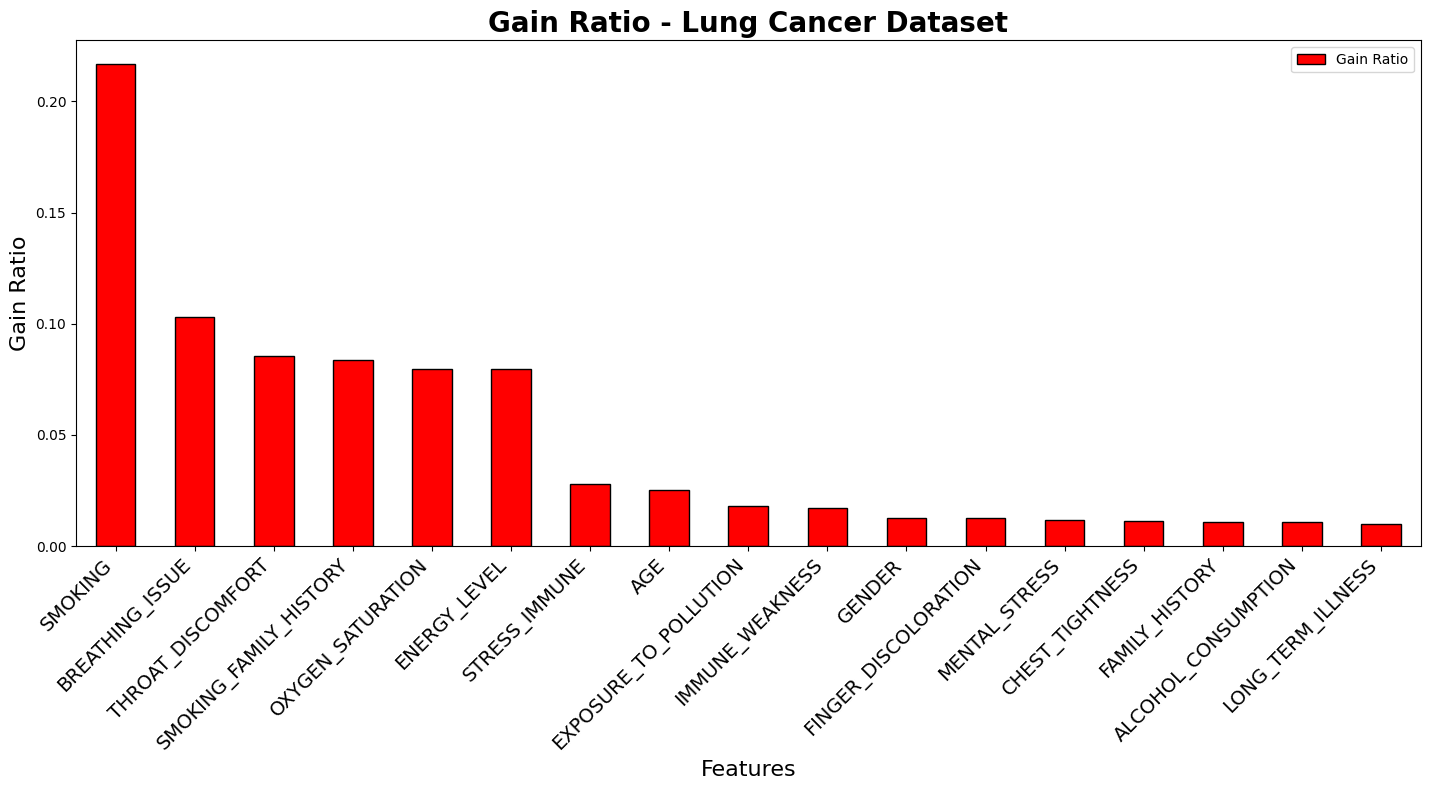

In [ ]:
# Gain Ratio
def entropy(y_res):
    value_counts = y_res.value_counts(normalize=True)
    return -np.sum(value_counts * np.log2(value_counts + 1e-9))

def information_gain(X_res, y_res, feature):
    base_entropy = entropy(y_res)
    feature_entropy = 0
    for value in X_res[feature].unique():
        subset = y_res[X_res[feature] == value]
        feature_entropy += len(subset) / len(X_res) * entropy(subset)
    return base_entropy - feature_entropy

def split_information(X_res, feature):
    value_counts = X_res[feature].value_counts(normalize=True)
    return -np.sum(value_counts * np.log2(value_counts + 1e-9))

def gain_ratio(X_res, y_res, feature):
    ig = information_gain(X_res, y_res, feature)
    si = split_information(X_res, feature)
    return ig / (si + 1e-9)

gain_ratios = {feature: gain_ratio(X_res, y_res, feature) for feature in X_res.columns}
gain_ratio_results = pd.DataFrame(gain_ratios.items(), columns=['Feature', 'Gain Ratio'])
gain_ratio_results = gain_ratio_results.sort_values(by="Gain Ratio", ascending=False)
print(gain_ratio_results)

plt.figure(figsize=(28, 8))
ax1 = plt.subplot(1, 2, 1)
gain_ratio_results.plot(kind='bar', color='red', edgecolor='black', ax=ax1)
ax1.set_title('Gain Ratio - Lung Cancer Dataset', fontsize=20, fontweight='bold')
ax1.set_xlabel('Features', fontsize=16)
ax1.set_ylabel('Gain Ratio', fontsize=16)
ax1.set_xticklabels(gain_ratio_results['Feature'], rotation=45, ha='right', fontsize=14)
plt.tight_layout()
plt.savefig("Gain_Ratio_LungCancer.pdf")
plt.show()

RFE Selected Features: ['AGE', 'SMOKING', 'EXPOSURE_TO_POLLUTION', 'ENERGY_LEVEL', 'BREATHING_ISSUE', 'THROAT_DISCOMFORT', 'OXYGEN_SATURATION', 'FAMILY_HISTORY', 'SMOKING_FAMILY_HISTORY', 'STRESS_IMMUNE']


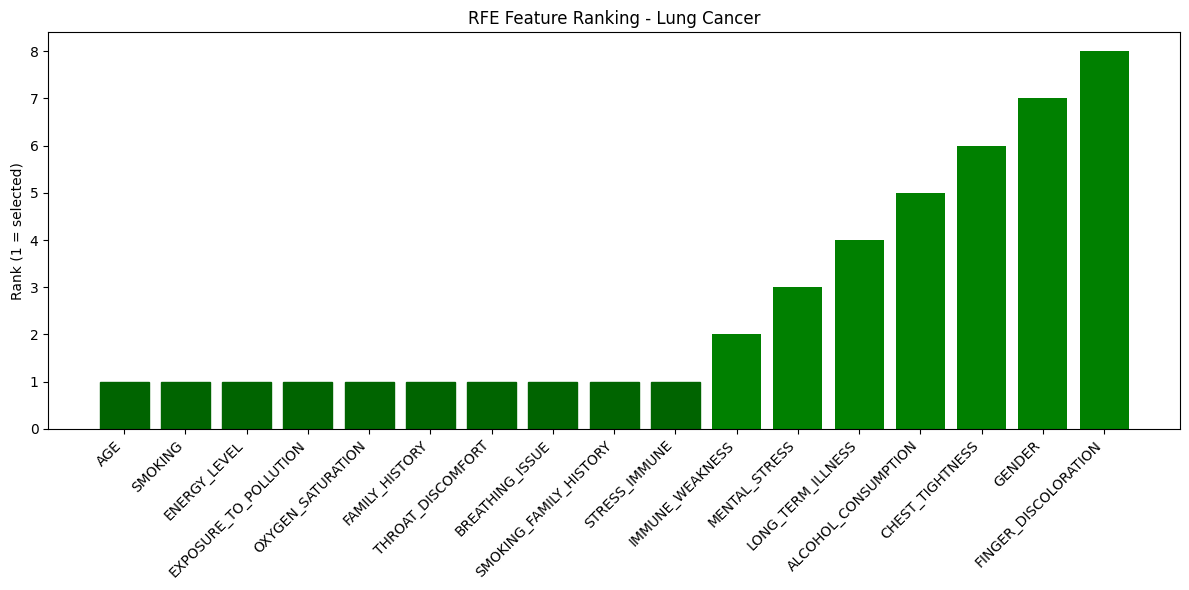

In [ ]:
# RFE with Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rfe = RFE(estimator=rf_model, n_features_to_select=10)
rfe.fit(X_res, y_res)

selected_features = X_res.columns[rfe.support_]
print("RFE Selected Features:", selected_features.tolist())

rank_df = pd.DataFrame({'Feature': X_res.columns, 'Rank': rfe.ranking_}).sort_values('Rank')
plt.figure(figsize=(12,6))
bars = plt.bar(rank_df['Feature'], rank_df['Rank'], color='green')
for bar, rank in zip(bars, rank_df['Rank']):
    if rank == 1: bar.set_color('darkgreen')
plt.xticks(rotation=45, ha='right')
plt.title('RFE Feature Ranking - Lung Cancer')
plt.ylabel('Rank (1 = selected)')
plt.tight_layout()
plt.savefig("RFE_Ranking_LungCancer.pdf")
plt.show()

Top 10 Hybrid Selected Features:
['SMOKING', 'BREATHING_ISSUE', 'THROAT_DISCOMFORT', 'SMOKING_FAMILY_HISTORY', 'ENERGY_LEVEL', 'STRESS_IMMUNE', 'OXYGEN_SATURATION', 'FAMILY_HISTORY', 'EXPOSURE_TO_POLLUTION', 'AGE']


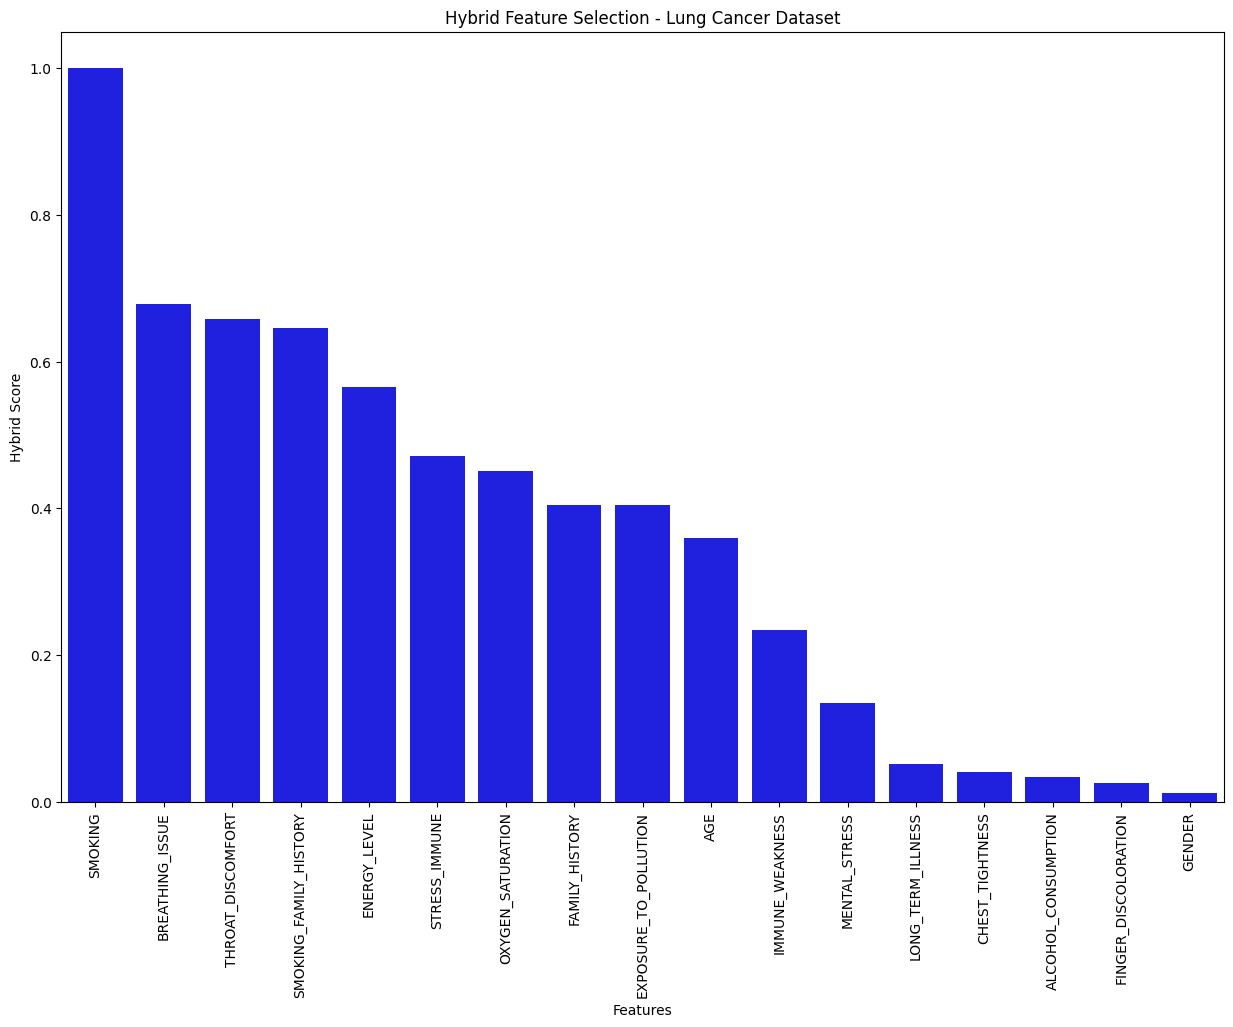

In [ ]:
# Hybrid Scoring
pearson_corr = X_res.apply(lambda col: abs(np.corrcoef(col, y_res)[0, 1])).to_frame(name='Pearson')

# Re-create gain_ratio_results from the original dictionary to ensure 'Feature' is a column
gain_ratio_results = pd.DataFrame(gain_ratios.items(), columns=['Feature', 'Gain Ratio'])
gain_ratio_results = gain_ratio_results.sort_values(by="Gain Ratio", ascending=False)
# Now, set the index and rename the column
gain_ratio_results = gain_ratio_results.set_index('Feature').rename(columns={'Gain Ratio': 'GR'})

rfe_scores = pd.DataFrame({'Feature': X_res.columns, 'RFE_Rank': rfe.ranking_})
rfe_scores['RFE'] = 1 / rfe_scores['RFE_Rank']
rfe_scores = rfe_scores.set_index('Feature')[['RFE']]

feature_scores = pearson_corr.join(gain_ratio_results, how='outer').join(rfe_scores, how='outer').fillna(0)
feature_scores_norm = (feature_scores - feature_scores.min()) / (feature_scores.max() - feature_scores.min() + 1e-8)
weights = {'Pearson': 0.33, 'GR': 0.34, 'RFE': 0.33}
feature_scores_norm['Hybrid_Score'] = (
    feature_scores_norm['Pearson'] * weights['Pearson'] +
    feature_scores_norm['GR'] * weights['GR'] +
    feature_scores_norm['RFE'] * weights['RFE']
)
feature_scores_norm = feature_scores_norm.sort_values(by='Hybrid_Score', ascending=False)

print("Top 10 Hybrid Selected Features:")
top_features = feature_scores_norm.head(10).index.tolist()
print(top_features)

plt.figure(figsize=(15,10))
sns.barplot(x=feature_scores_norm.index, y=feature_scores_norm['Hybrid_Score'], color='blue')
plt.xticks(rotation=90)
plt.title("Hybrid Feature Selection - Lung Cancer Dataset")
plt.xlabel("Features")
plt.ylabel("Hybrid Score")
plt.savefig("Hybrid_Feature_Selection_LungCancer.pdf", bbox_inches='tight')
plt.show()

In [ ]:
# Selected top 10 Features
top_n = 10
top_features = feature_scores_norm.head(top_n).index.tolist()
df_selected = X_res[top_features]

print("Top 10 selected features:")
for i, feature in enumerate(top_features, start=1):
    print(f"{i}. {feature}")

Top 10 selected features:
1. SMOKING
2. BREATHING_ISSUE
3. THROAT_DISCOMFORT
4. SMOKING_FAMILY_HISTORY
5. ENERGY_LEVEL
6. STRESS_IMMUNE
7. OXYGEN_SATURATION
8. FAMILY_HISTORY
9. EXPOSURE_TO_POLLUTION
10. AGE


In [ ]:
# Use top 10 features
df_selected = X_res[top_features]
X_train, X_test, y_train, y_test = train_test_split(
    df_selected, y_res, test_size=0.2, random_state=42, stratify=y_res
)

##Initial Model's----------------------------------

RF

In [ ]:
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

joblib.dump(rf, 'Initial_RandomForest_LungCancer.pkl')

y_pred = rf.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred)
precision_rf = precision_score(y_test, y_pred)
recall_rf = recall_score(y_test, y_pred)
f1_rf = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy_rf}")
print(f"Precision: {precision_rf}")
print(f"Recall: {recall_rf}")
print(f"F1 Score: {f1_rf}")

Accuracy: 0.9165261382799326
Precision: 0.9186440677966101
Recall: 0.9139966273187183
F1 Score: 0.9163144547759933


DT

In [ ]:
import joblib
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

joblib.dump(dt, 'Initial_LungCancer_DecisionTree.pkl')

y_pred_dt = dt.predict(X_test)

accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)

print(f"Accuracy: {accuracy_dt}")
print(f"Precision: {precision_dt}")
print(f"Recall: {recall_dt}")
print(f"F1 Score: {f1_dt}")

Accuracy: 0.8558178752107926
Precision: 0.8600682593856656
Recall: 0.8499156829679595
F1 Score: 0.8549618320610687


LR

In [ ]:
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

joblib.dump(lr, 'Initial_LungCancer_LogisticRegression.pkl')

y_pred_lr = lr.predict(X_test)

accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print(f"Accuracy: {accuracy_lr}")
print(f"Precision: {precision_lr}")
print(f"Recall: {recall_lr}")
print(f"F1 Score: {f1_lr}")

Accuracy: 0.8895446880269815
Precision: 0.8701923076923077
Recall: 0.9156829679595279
F1 Score: 0.8923582580115037


NB

In [ ]:
import joblib
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

joblib.dump(nb_model, 'Initial_LungCancer_NaiveBayes.pkl')

y_pred = nb_model.predict(X_test)

accuracy_nb = accuracy_score(y_test, y_pred)
precision_nb = precision_score(y_test, y_pred)
recall_nb = recall_score(y_test, y_pred)
f1_nb = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy_nb}")
print(f"Precision: {precision_nb}")
print(f"Recall: {recall_nb}")
print(f"F1 Score: {f1_nb}")

Accuracy: 0.857504215851602
Precision: 0.8375796178343949
Recall: 0.8870151770657673
F1 Score: 0.8615888615888616


XGB

In [ ]:
import joblib
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)

joblib.dump(xgb, 'Initial_LungCancer_XGBoost.pkl')

y_pred_xgb = xgb.predict(X_test)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

print(f"Accuracy: {accuracy_xgb}")
print(f"Precision: {precision_xgb}")
print(f"Recall: {recall_xgb}")
print(f"F1 Score: {f1_xgb}")

Accuracy: 0.903035413153457
Precision: 0.9037162162162162
Recall: 0.9021922428330523
F1 Score: 0.9029535864978903


SVM

In [ ]:
import joblib
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train)

joblib.dump(svm_model, 'Initial_LungCancer_SVM.pkl')

y_pred = svm_model.predict(X_test)

accuracy_svm = accuracy_score(y_test, y_pred)
precision_svm = precision_score(y_test, y_pred)
recall_svm = recall_score(y_test, y_pred)
f1_svm = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy_svm}")
print(f"Precision: {precision_svm}")
print(f"Recall: {recall_svm}")
print(f"F1 Score: {f1_svm}")

Accuracy: 0.9047217537942664
Precision: 0.9013377926421404
Recall: 0.9089376053962901
F1 Score: 0.9051217464315701


In [ ]:
import joblib
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

rf = joblib.load('Initial_RandomForest_LungCancer.pkl')
dt = joblib.load('Initial_LungCancer_DecisionTree.pkl')
lr = joblib.load('Initial_LungCancer_LogisticRegression.pkl')
nb = joblib.load('Initial_LungCancer_NaiveBayes.pkl')
xgb = joblib.load('Initial_LungCancer_XGBoost.pkl')
svm = joblib.load('Initial_LungCancer_SVM.pkl')

base_learners = [
    ('rf', rf),
    ('dt', dt),
    ('lr', lr),
    ('nb', nb),
    ('xgb', xgb),
    ('svm', svm)
]

meta_model = LogisticRegression(random_state=42)

stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_model)
stacking_model.fit(X_train, y_train)

y_pred = stacking_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

joblib.dump(stacking_model, 'Initial_LungCancer_Stacking.pkl')

Accuracy: 0.918212478920742
Precision: 0.918918918918919
Recall: 0.9173693086003373
F1 Score: 0.9181434599156119


['Initial_LungCancer_Stacking.pkl']

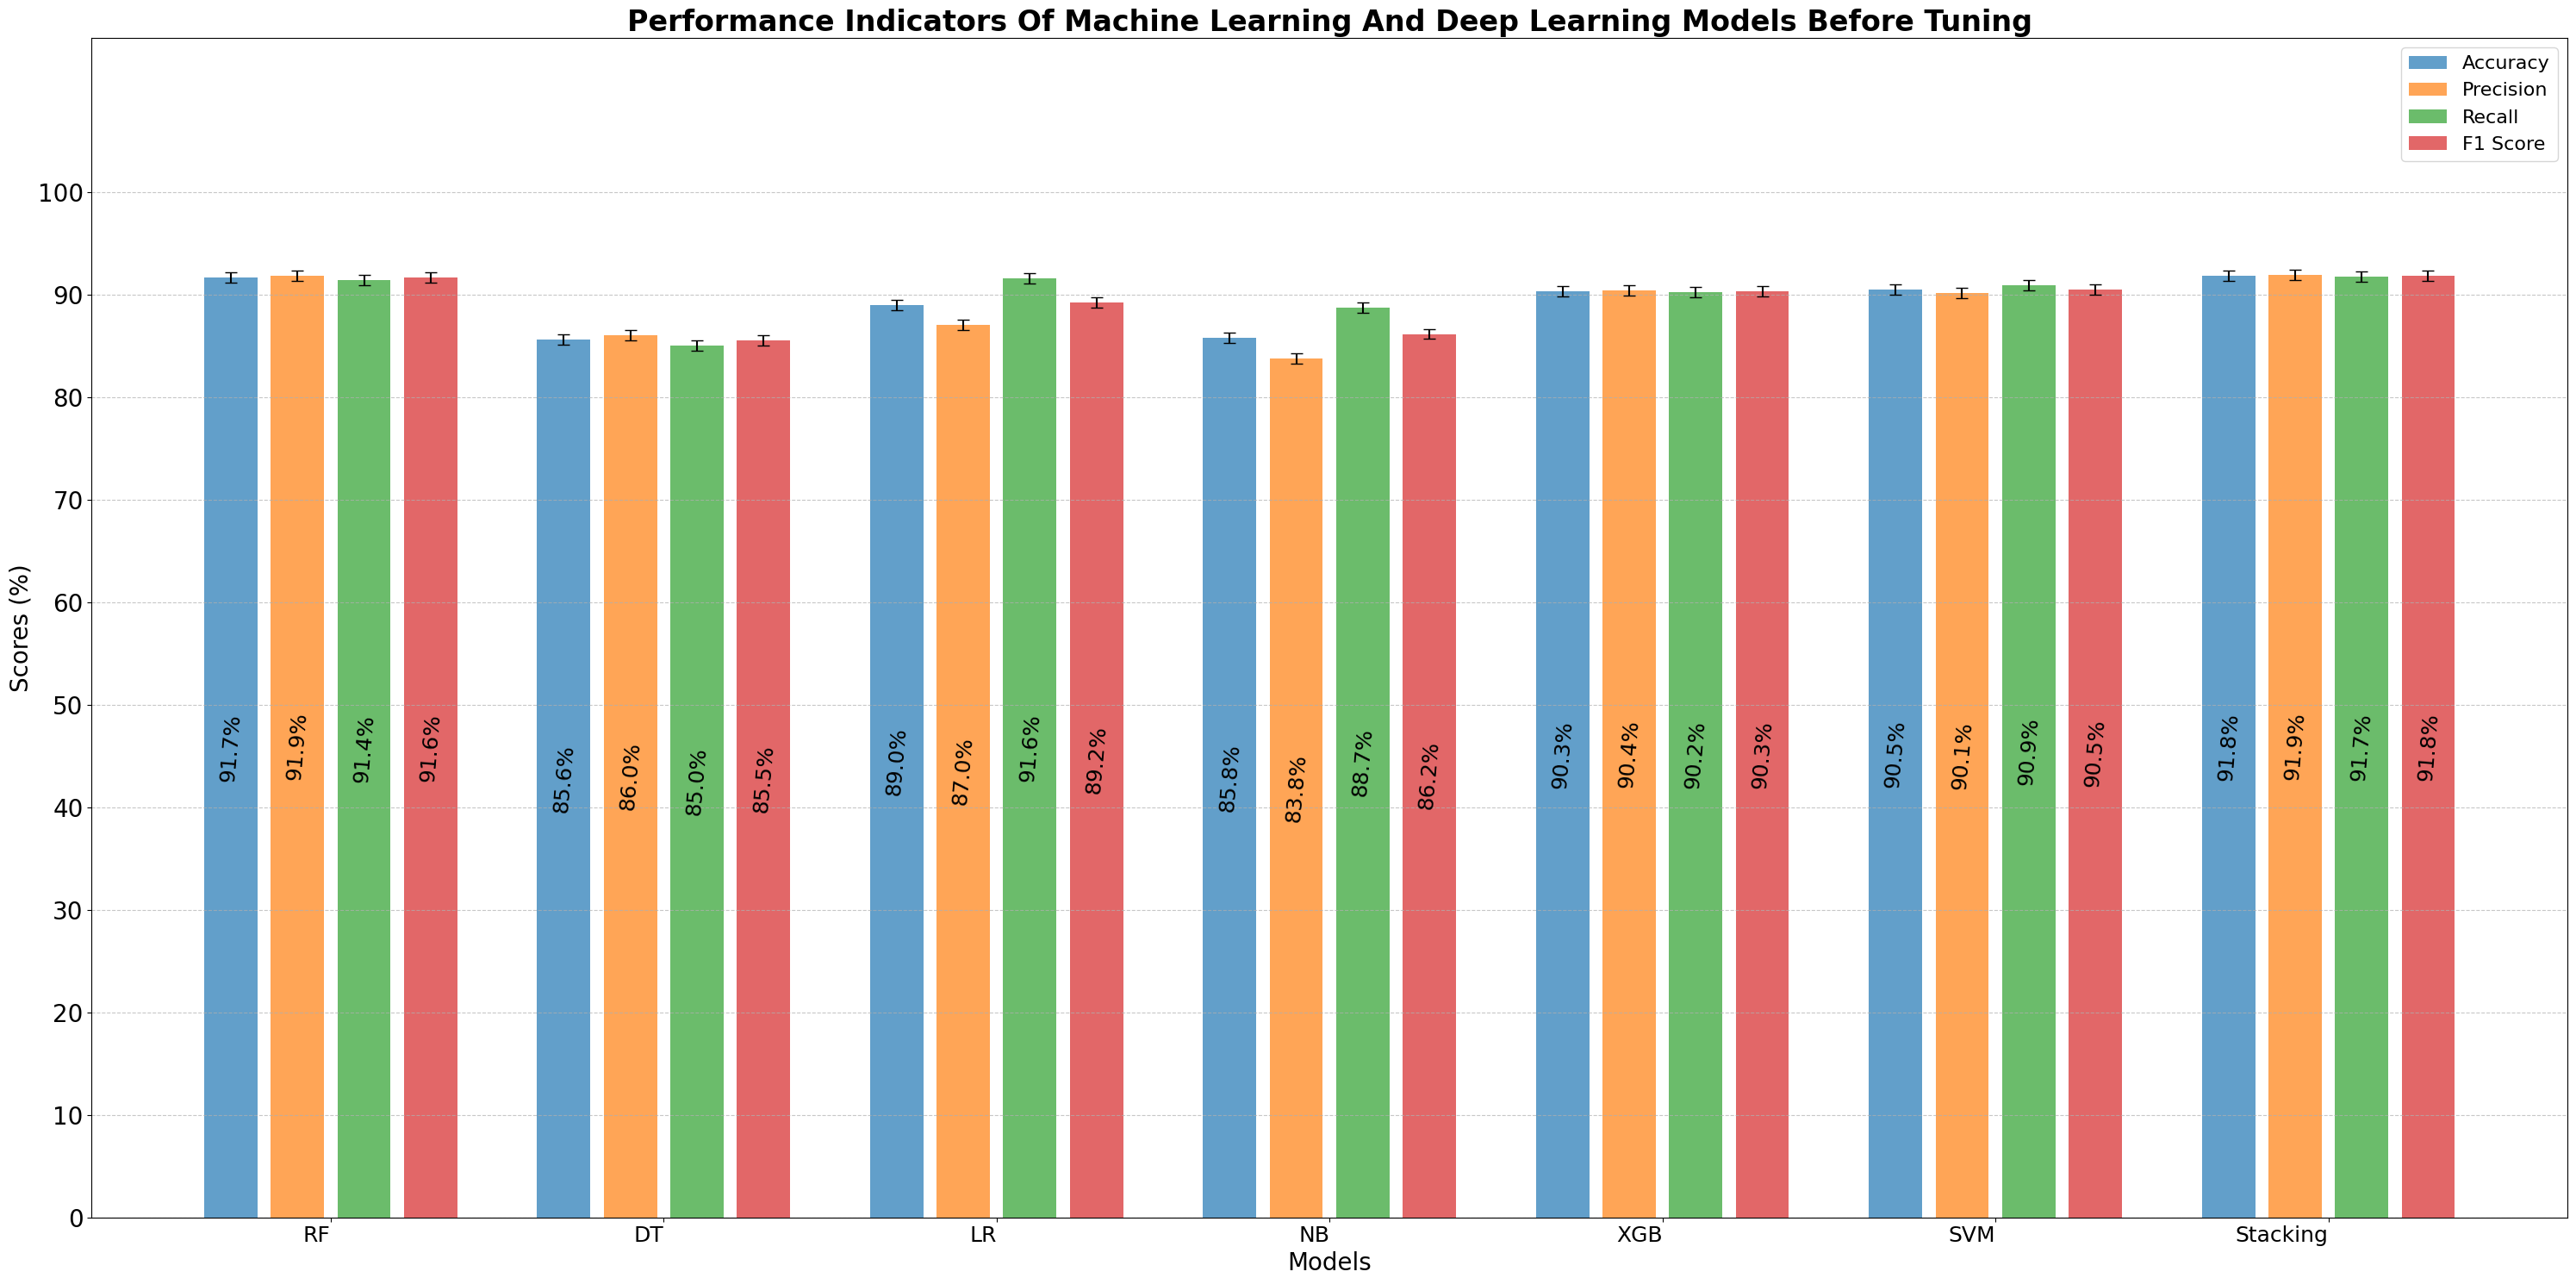

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

models = ['RF', 'DT', 'LR', 'NB', 'XGB', 'SVM', 'Stacking']

accuracy = [91.65, 85.58, 88.95, 85.75, 90.30, 90.47, 91.82]
precision = [91.86, 86.01, 87.02, 83.76, 90.37, 90.13, 91.89]
recall = [91.40, 84.99, 91.57, 88.70, 90.22, 90.89, 91.74]
f1_score = [91.63, 85.50, 89.24, 86.16, 90.30, 90.51, 91.81]

accuracy_errors = [0.5] * len(models)
precision_errors = [0.5] * len(models)
recall_errors = [0.5] * len(models)
f1_score_errors = [0.5] * len(models)

metrics = [accuracy, precision, recall, f1_score]
metrics_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
metrics_errors = [accuracy_errors, precision_errors, recall_errors, f1_score_errors]

x_pos = np.arange(len(models))
width = 0.2

fig, ax = plt.subplots(figsize=(30, 15))

for i, (metric, label, errors) in enumerate(zip(metrics, metrics_labels, metrics_errors)):
    bar = ax.bar(
        x_pos + i * width, metric, width * 0.8, yerr=errors,
        label=label, alpha=0.7, ecolor='black', capsize=5
    )

    for j, (rect, value) in enumerate(zip(bar, metric)):
        height = rect.get_height()

        offset_x = rect.get_x() + rect.get_width() / 2.0
        offset_y = height * 0.5

        ax.text(
            offset_x,
            offset_y,
            f'{value:.1f}%',
            ha='center',
            va='center',
            fontsize=18,
            color='black',
            rotation=85,
            rotation_mode='anchor'
        )

ax.set_title('Performance Indicators Of Machine Learning And Deep Learning Models Before Tuning', fontsize=24, weight='bold')
ax.set_xlabel('Models', fontsize=20)
ax.set_ylabel('Scores (%)', fontsize=20)
ax.set_xticks(x_pos + width * 1.5)
ax.set_xticklabels(models, ha='right', fontsize=18)
ax.set_ylim(0, 115)
ax.set_yticks(np.arange(0, 110, 10))
ax.tick_params(axis='y', labelsize=20)
ax.legend(fontsize=16, loc='upper right', bbox_to_anchor=(1, 1))
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()

plt.savefig('model_performance_plot Before Tuning.pdf', format='pdf')
plt.show()

##Tuning Models-----------------------------------------

RF

In [ ]:
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(10, 100),
    'max_depth': randint(10, 50),
    'min_samples_leaf': randint(1, 10),
    'min_samples_split': randint(2, 10)
}

rf = RandomForestClassifier(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=20, cv=cv, n_jobs=-1, scoring='accuracy', random_state=42)
random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best cross-validation score: {:.2f}".format(random_search.best_score_))

best_rf = random_search.best_estimator_
models = {}
models['RandomForest'] = best_rf
joblib.dump(best_rf, 'Best_RandomForest_LungCancer.pkl')

y_pred = best_rf.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred)
precision_rf = precision_score(y_test, y_pred, average='binary')
recall_rf = recall_score(y_test, y_pred, average='binary')
f1_rf = f1_score(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy_rf}")
print(f"Precision: {precision_rf}")
print(f"Recall: {recall_rf}")
print(f"F1 Score: {f1_rf}")

Best parameters: {'max_depth': 44, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 59}
Best cross-validation score: 0.92
Accuracy: 0.9173693086003373
Precision: 0.9216354344122658
Recall: 0.9123102866779089
F1 Score: 0.9169491525423729


DT

In [ ]:
import joblib
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.stats import randint

param_dist = {
    'max_depth': randint(10, 50),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5)
}

dt = DecisionTreeClassifier(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search_dt = RandomizedSearchCV(estimator=dt, param_distributions=param_dist, n_iter=20, cv=cv, n_jobs=-1, scoring='accuracy', random_state=42)
random_search_dt.fit(X_train, y_train)

print("Best parameters found: ", random_search_dt.best_params_)
print("Best cross-validation score: {:.2f}".format(random_search_dt.best_score_))

dt_best = random_search_dt.best_estimator_
models = {}
models['DecisionTree'] = dt_best

joblib.dump(dt_best, 'Best_LungCancer_DecisionTree.pkl')

y_pred_dt = dt_best.predict(X_test)

accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt, average='binary')
recall_dt = recall_score(y_test, y_pred_dt, average='binary')
f1_dt = f1_score(y_test, y_pred_dt, average='binary')

print(f"Accuracy: {accuracy_dt}")
print(f"Precision: {precision_dt}")
print(f"Recall: {recall_dt}")
print(f"F1 Score: {f1_dt}")

Best parameters found:  {'max_depth': 11, 'min_samples_leaf': 4, 'min_samples_split': 5}
Best cross-validation score: 0.90
Accuracy: 0.8844856661045531
Precision: 0.8851351351351351
Recall: 0.8836424957841484
F1 Score: 0.8843881856540085


LR

In [ ]:
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.stats import uniform

param_dist = {
    'C': uniform(1, 50),
    'solver': ['liblinear', 'saga'],
    'penalty': ['l1', 'l2']
}

lr = LogisticRegression(max_iter=1000, random_state=42)

random_search_lr = RandomizedSearchCV(estimator=lr, param_distributions=param_dist, n_iter=20, cv=5, n_jobs=-1, scoring='accuracy', random_state=42)
random_search_lr.fit(X_train, y_train)

print("Best parameters found: ", random_search_lr.best_params_)
print("Best cross-validation score: {:.2f}".format(random_search_lr.best_score_))

best_lr = random_search_lr.best_estimator_
models = {}
models['LogisticRegression'] = best_lr

joblib.dump(best_lr, 'Best_LungCancer_LogisticRegression.pkl')

y_pred_lr = best_lr.predict(X_test)

accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print(f"Accuracy: {accuracy_lr}")
print(f"Precision: {precision_lr}")
print(f"Recall: {recall_lr}")
print(f"F1 Score: {f1_lr}")

Best parameters found:  {'C': np.float64(19.727005942368123), 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation score: 0.89
Accuracy: 0.8895446880269815
Precision: 0.8701923076923077
Recall: 0.9156829679595279
F1 Score: 0.8923582580115037


NB

In [ ]:
import joblib
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.stats import uniform

param_dist = {
    'var_smoothing': np.logspace(-11, -8, 300)
}

nb_model = GaussianNB()

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search_nb = RandomizedSearchCV(estimator=nb_model, param_distributions=param_dist, n_iter=20, cv=cv, n_jobs=-1, scoring='accuracy', random_state=42)
random_search_nb.fit(X_train, y_train)

print(f"Best Parameters: {random_search_nb.best_params_}")
print(f"Best Cross-validation Score: {random_search_nb.best_score_}")

best_nb = random_search_nb.best_estimator_
models = {}
models['NaiveBayes'] = best_nb

joblib.dump(best_nb, 'Best_LungCancer_NaiveBayes.pkl')

y_pred = best_nb.predict(X_test)

accuracy_nb = accuracy_score(y_test, y_pred)
precision_nb = precision_score(y_test, y_pred)
recall_nb = recall_score(y_test, y_pred)
f1_nb = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy_nb}")
print(f"Precision: {precision_nb}")
print(f"Recall: {recall_nb}")
print(f"F1 Score: {f1_nb}")

Best Parameters: {'var_smoothing': np.float64(1.0884019160690077e-09)}
Best Cross-validation Score: 0.8616033755274263
Accuracy: 0.857504215851602
Precision: 0.8375796178343949
Recall: 0.8870151770657673
F1 Score: 0.8615888615888616


XGB


In [ ]:
import joblib
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.stats import uniform

param_dist = {
    'n_estimators': [100, 200, 250, 300],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.7, 0.8, 0.9]
}

xgboost_model = XGBClassifier(random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search_xgb = RandomizedSearchCV(estimator=xgboost_model, param_distributions=param_dist, n_iter=20, cv=cv, scoring='accuracy', n_jobs=-1, random_state=42)
random_search_xgb.fit(X_train, y_train)

print(f"Best Parameters: {random_search_xgb.best_params_}")
print(f"Best Cross-validation Score: {random_search_xgb.best_score_}")

best_xgb = random_search_xgb.best_estimator_
models = {}
models['XGBoost'] = best_xgb

joblib.dump(best_xgb, 'Best_LungCancer_XGBoost.pkl')

y_pred_xgb = best_xgb.predict(X_test)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

print(f"Accuracy: {accuracy_xgb:.2f}")
print(f"Precision: {precision_xgb:.2f}")
print(f"Recall: {recall_xgb:.2f}")
print(f"F1 Score: {f1_xgb:.2f}")

Best Parameters: {'subsample': 0.7, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.01}
Best Cross-validation Score: 0.9145569620253164
Accuracy: 0.92
Precision: 0.92
Recall: 0.91
F1 Score: 0.92


svm

In [ ]:
import joblib
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.stats import uniform

param_dist = {
    'C': uniform(350, 100),
    'kernel': ['linear', 'poly'],
    'gamma': uniform(0.05, 0.1)
}

svm_model = SVC(random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search_svm = RandomizedSearchCV(estimator=svm_model, param_distributions=param_dist, n_iter=20, cv=cv, scoring='accuracy', n_jobs=-1, random_state=42)
random_search_svm.fit(X_train, y_train)

print(f"Best Parameters: {random_search_svm.best_params_}")
print(f"Best Cross-validation Score: {random_search_svm.best_score_}")

best_svm = random_search_svm.best_estimator_
models = {}
models['SVM'] = best_svm

joblib.dump(best_svm, 'Best_LungCancer_SVM.pkl')

y_pred = best_svm.predict(X_test)

accuracy_svm = accuracy_score(y_test, y_pred)
precision_svm = precision_score(y_test, y_pred)
recall_svm = recall_score(y_test, y_pred)
f1_svm = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy_svm:.2f}")
print(f"Precision: {precision_svm:.2f}")
print(f"Recall: {recall_svm:.2f}")
print(f"F1 Score: {f1_svm:.2f}")

Best Parameters: {'C': np.float64(427.9691000272769), 'gamma': np.float64(0.1096850157946487), 'kernel': 'poly'}
Best Cross-validation Score: 0.909915611814346
Accuracy: 0.91
Precision: 0.91
Recall: 0.92
F1 Score: 0.91


In [ ]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb
import numpy as np
import joblib

base_learners = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42)),
    ('nb', GaussianNB()),
    ('xgb', xgb.XGBClassifier(random_state=42, eval_metric='logloss')),
    ('svm', SVC(probability=True, random_state=42))
]

meta_learner = LogisticRegression(max_iter=1000)

stack_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    n_jobs=-1,
    passthrough=False
    stack_method='predict_proba'
)

param_distributions = {
    'xgb__n_estimators': [200, 500, 800],
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__max_depth': [4, 6, 8],
    'rf__n_estimators': [300, 500, 800],
    'rf__max_depth': [20, 30, 40],
    'dt__max_depth': [10, 15, 20],
    'dt__min_samples_split': [2, 5, 10],
    'svm__C': [0.5, 1.0, 2.0, 5.0],
    'svm__kernel': ['rbf', 'poly'],
    'nb__var_smoothing': np.logspace(-9, -1, 10),
    'final_estimator__C': [1.0, 5.0, 10.0, 20.0]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=stack_model,
    param_distributions=param_distributions,
    n_iter=20,
    scoring='f1',
    cv=skf,
    n_jobs=-1,
    verbose=2
)

random_search.fit(X_train, y_train)
best_stack = random_search.best_estimator_

y_test_pred_stack = best_stack.predict(X_test)

print(f"Best Parameters: {random_search.best_params_}")

accuracy_stack1 = accuracy_score(y_test, y_test_pred_stack)
precision_stack1 = precision_score(y_test, y_test_pred_stack)
recall_stack1 = recall_score(y_test, y_test_pred_stack)
f1_stack1 = f1_score(y_test, y_test_pred_stack)

print(f"Accuracy: {accuracy_stack1}")
print(f"Precision: {precision_stack1}")
print(f"Recall: {recall_stack1}")
print(f"F1 Score: {f1_stack1}")
joblib.dump(best_stack, 'LungCancer_Stacking_100.pkl')

Best Threshold: 0.658
Accuracy: 0.9216
Precision: 0.9310
Recall: 0.9106
F1 Score: 0.9207


['LungCancer_Stacking_100.pkl']

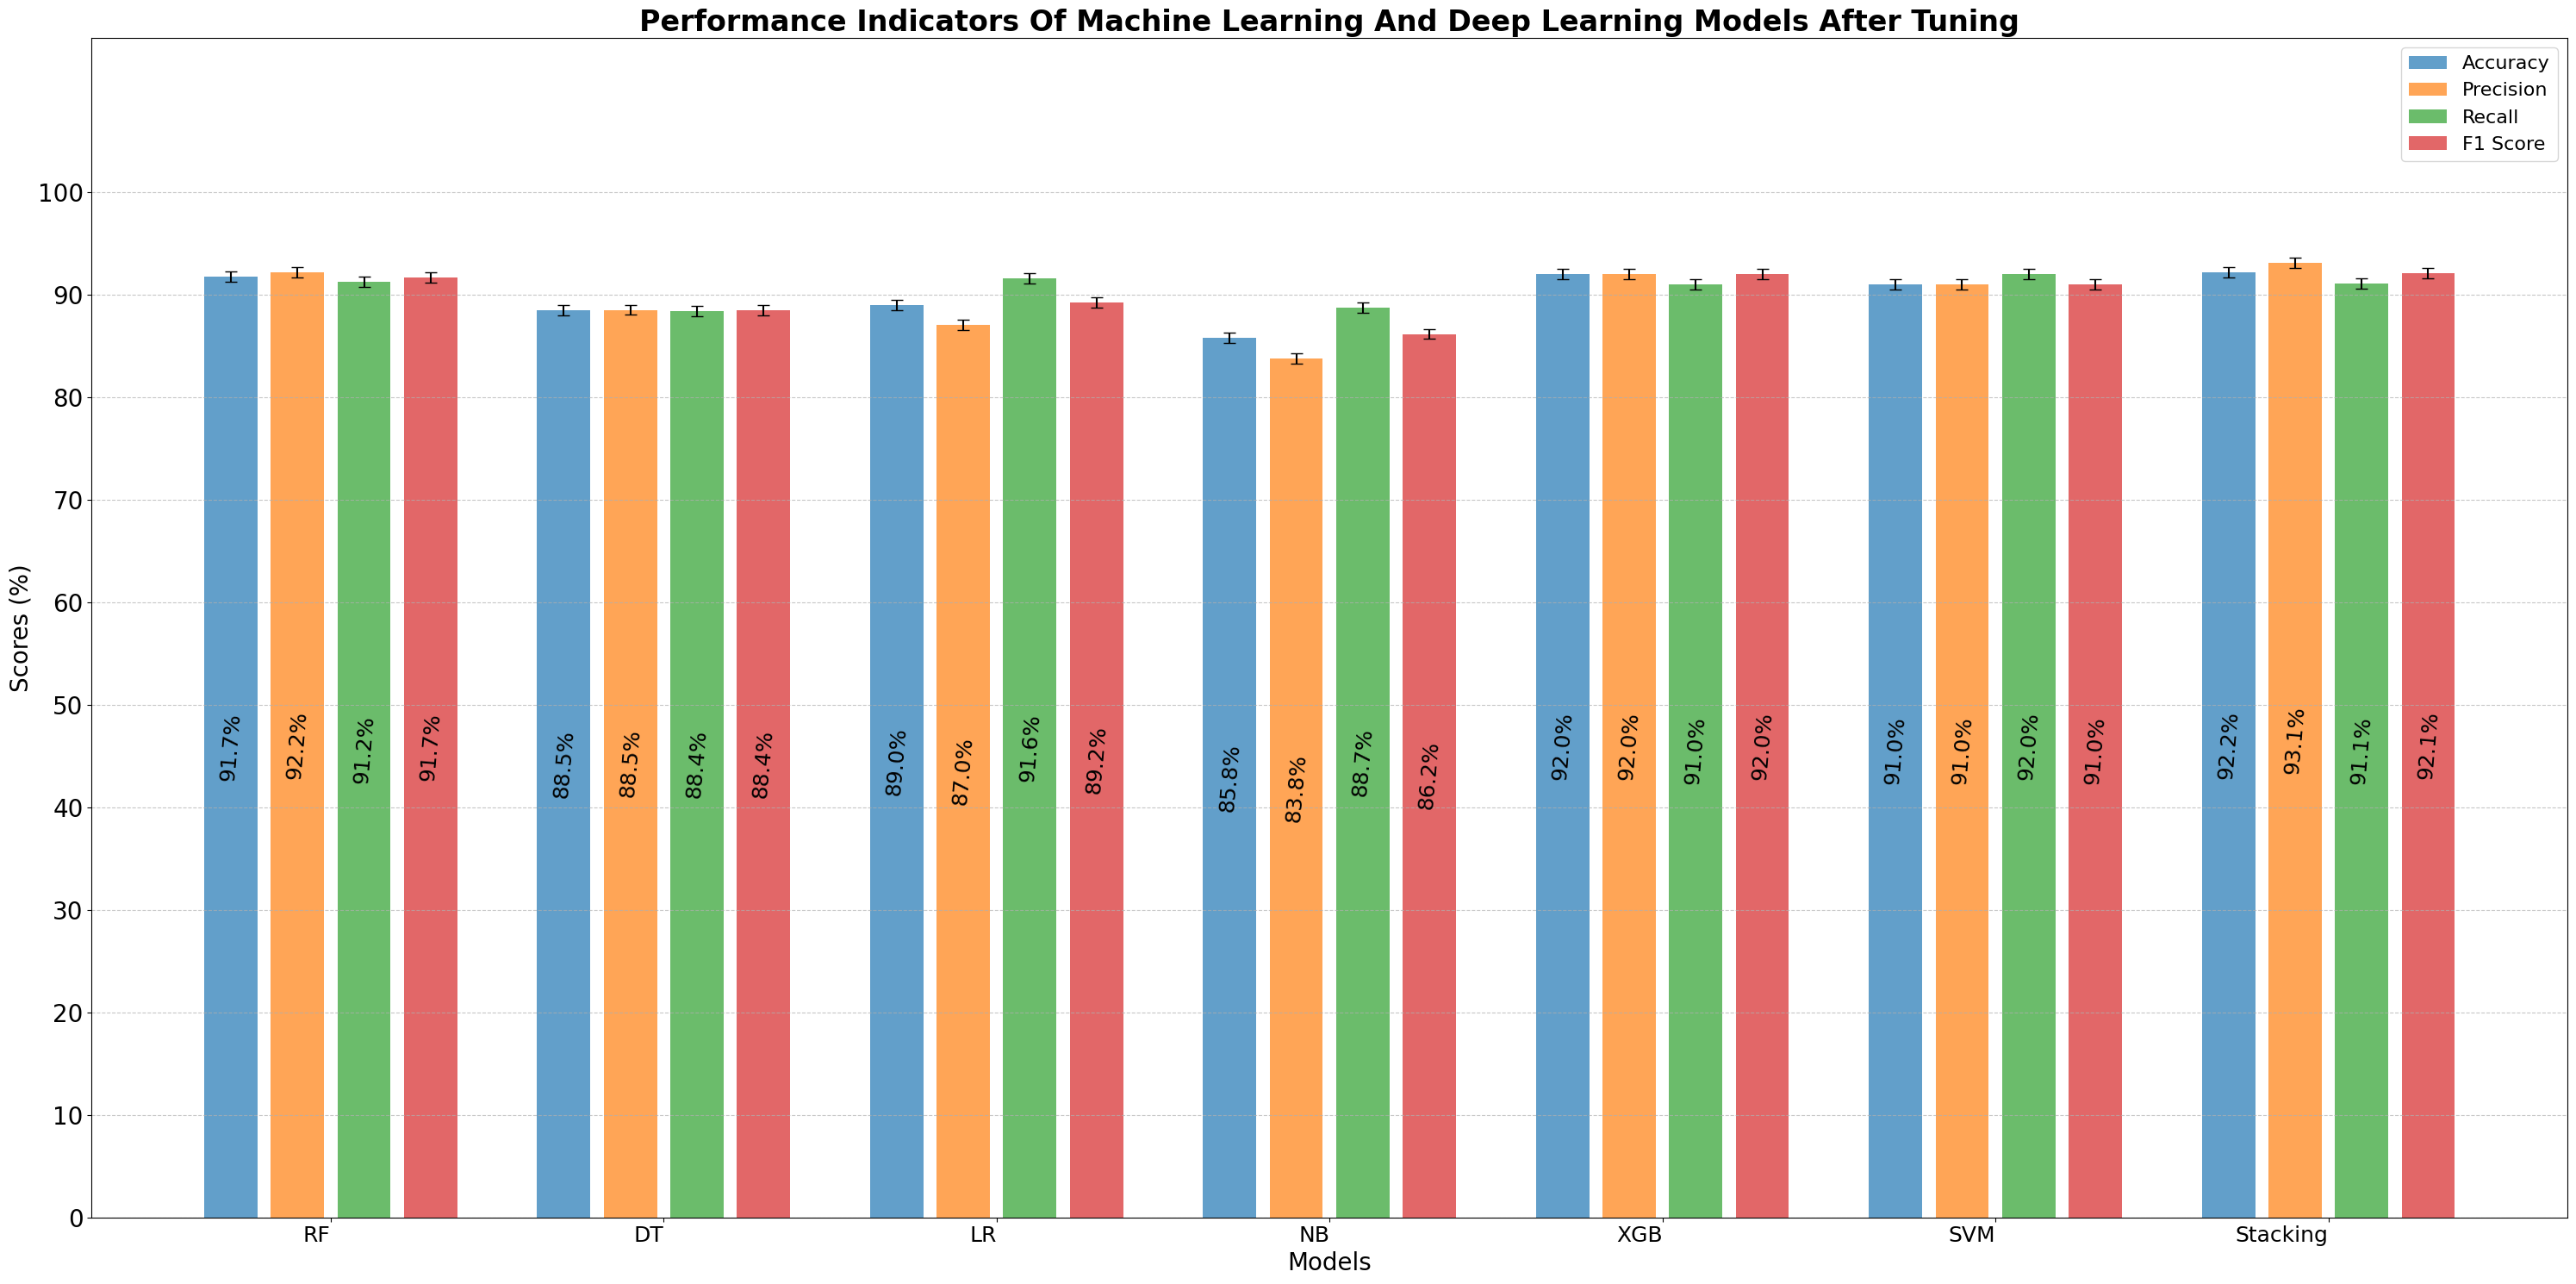

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

models = ['RF', 'DT', 'LR', 'NB', 'XGB', 'SVM', 'Stacking']

accuracy = [91.74, 88.45, 88.95, 85.75, 92.00, 91.00, 92.16]
precision = [92.16, 88.51, 87.02, 83.76, 92.00, 91.00, 93.10]
recall = [91.23, 88.36, 91.57, 88.70, 91.00, 92.00, 91.06]
f1_score = [91.69, 88.44, 89.24, 86.16, 92.00, 91.00, 92.07]

accuracy_errors = [0.5] * len(models)
precision_errors = [0.5] * len(models)
recall_errors = [0.5] * len(models)
f1_score_errors = [0.5] * len(models)

metrics = [accuracy, precision, recall, f1_score]
metrics_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
metrics_errors = [accuracy_errors, precision_errors, recall_errors, f1_score_errors]

x_pos = np.arange(len(models))
width = 0.2

fig, ax = plt.subplots(figsize=(30, 15))

for i, (metric, label, errors) in enumerate(zip(metrics, metrics_labels, metrics_errors)):
    bar = ax.bar(
        x_pos + i * width, metric, width * 0.8, yerr=errors,
        label=label, alpha=0.7, ecolor='black', capsize=5
    )

    for j, (rect, value) in enumerate(zip(bar, metric)):
        height = rect.get_height()

        offset_x = rect.get_x() + rect.get_width() / 2.0
        offset_y = height * 0.5

        ax.text(
            offset_x,
            offset_y,
            f'{value:.1f}%',
            ha='center',
            va='center',
            fontsize=18,
            color='black',
            rotation=85,
            rotation_mode='anchor'
        )

ax.set_title('Performance Indicators Of Machine Learning And Deep Learning Models After Tuning', fontsize=24, weight='bold')
ax.set_xlabel('Models', fontsize=20)
ax.set_ylabel('Scores (%)', fontsize=20)
ax.set_xticks(x_pos + width * 1.5)
ax.set_xticklabels(models, ha='right', fontsize=18)
ax.set_ylim(0, 115)
ax.set_yticks(np.arange(0, 110, 10))
ax.tick_params(axis='y', labelsize=20)
ax.legend(fontsize=16, loc='upper right', bbox_to_anchor=(1, 1))
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()

plt.savefig('model_performance_plot After Tuning.pdf', format='pdf')
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

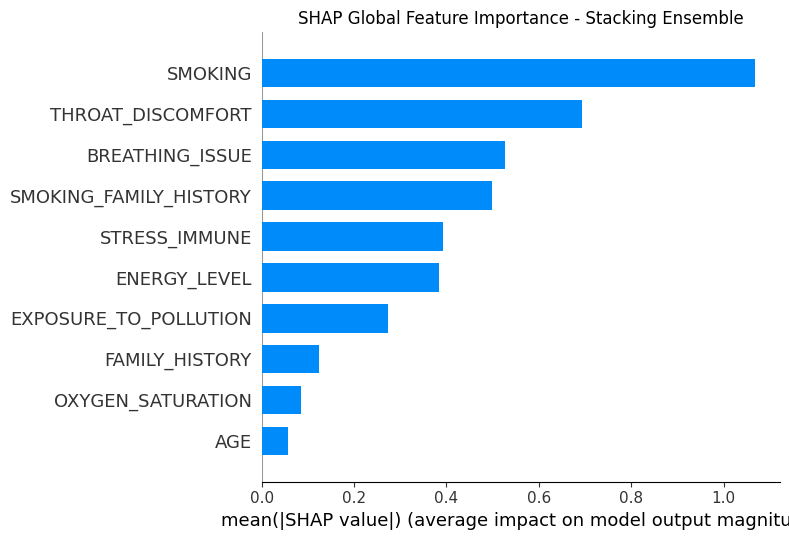

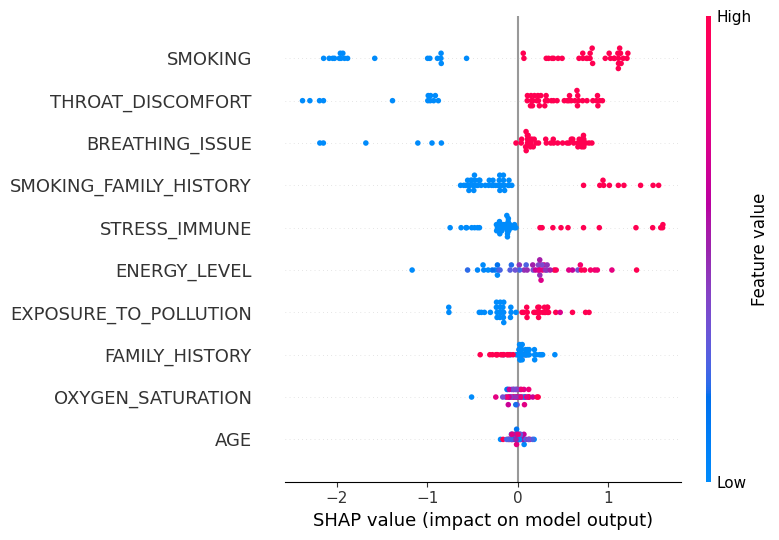

In [ ]:
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
import numpy as np
import joblib

best_stack = joblib.load('LungCancer_Stacking_100.pkl')

top_features = ['SMOKING', 'BREATHING_ISSUE', 'THROAT_DISCOMFORT', 'SMOKING_FAMILY_HISTORY', 'ENERGY_LEVEL',
                'STRESS_IMMUNE', 'OXYGEN_SATURATION', 'FAMILY_HISTORY', 'EXPOSURE_TO_POLLUTION', 'AGE']

X_train_display = X_train[top_features]
X_test_display  = X_test[top_features]

background = shap.sample(X_train_display, 100)
explainer = shap.KernelExplainer(best_stack.predict_proba, background, link="logit")

shap_values = explainer.shap_values(X_test_display.iloc[:50], nsamples=100)
shap_values_pos = shap_values[:, :, 1]

shap.summary_plot(shap_values_pos, X_test_display.iloc[:50], plot_type="bar", show=False)
plt.title("SHAP Global Feature Importance - Stacking Ensemble")
plt.tight_layout()
plt.savefig("SHAP_Global_Stacking.pdf", bbox_inches='tight')
plt.show()

shap.summary_plot(shap_values_pos, X_test_display.iloc[:50], show=False)
plt.tight_layout()
plt.savefig("SHAP_Summary_Stacking.pdf", bbox_inches='tight')
plt.show()

shap.initjs()
display(shap.force_plot(explainer.expected_value[1], shap_values_pos[0], X_test_display.iloc[0], link="logit"))

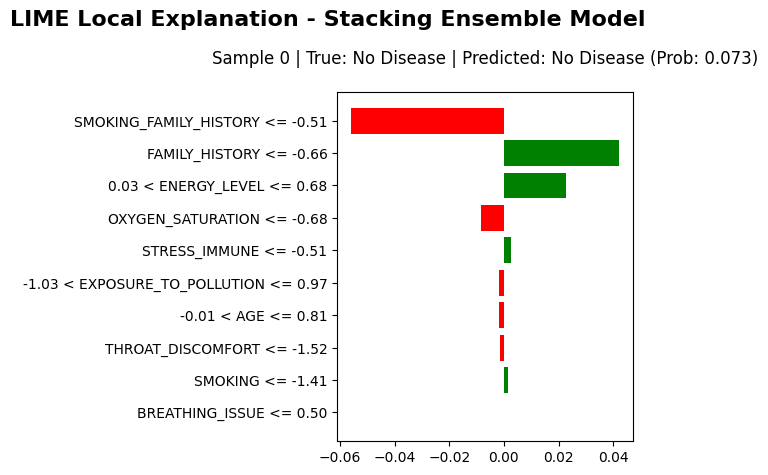

In [ ]:
lime_explainer = LimeTabularExplainer(
    training_data=X_train_display.values,
    feature_names=top_features,
    class_names=['No Lung Disease', 'Lung Disease'],
    mode='classification',
    discretize_continuous=True
)

idx = 0
instance = X_test_display.iloc[idx]
true_label = y_test.iloc[idx]
pred_label = best_stack.predict(X_test_display.iloc[idx:idx+1])[0]
pred_proba = best_stack.predict_proba(X_test_display.iloc[idx:idx+1])[0]

exp = lime_explainer.explain_instance(
    data_row=instance.values,
    predict_fn=best_stack.predict_proba,
    num_features=10,
    labels=[1]
)

fig = exp.as_pyplot_figure(label=1)
plt.suptitle("LIME Local Explanation - Stacking Ensemble Model", fontsize=16, fontweight='bold')
plt.title(f"Sample {idx} | True: {'Lung Disease' if true_label==1 else 'No Disease'} | "
          f"Predicted: {'Lung Disease' if pred_label==1 else 'No Disease'} (Prob: {pred_proba[1]:.3f})",
          fontsize=12, pad=20)

plt.tight_layout()
plt.savefig("LIME_Detailed_Final_Explanation.pdf", bbox_inches='tight', dpi=300)
plt.savefig("LIME_Detailed_Final_Explanation.png", bbox_inches='tight', dpi=300)
plt.show()

exp.save_to_file("LIME_Detailed_Interactive_Explanation.html")